In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

## Logistic regression

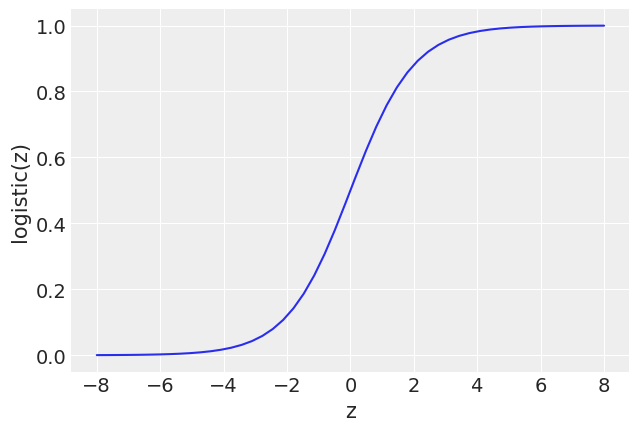

In [3]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel('z')
plt.ylabel('logistic(z)')
plt.savefig('B11197_04_01.png', dpi=300);

## The iris dataset

In [4]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


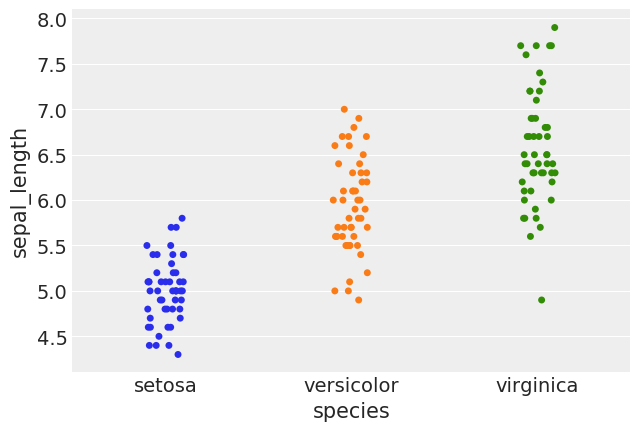

In [5]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
plt.savefig('B11197_04_02.png', dpi=300);

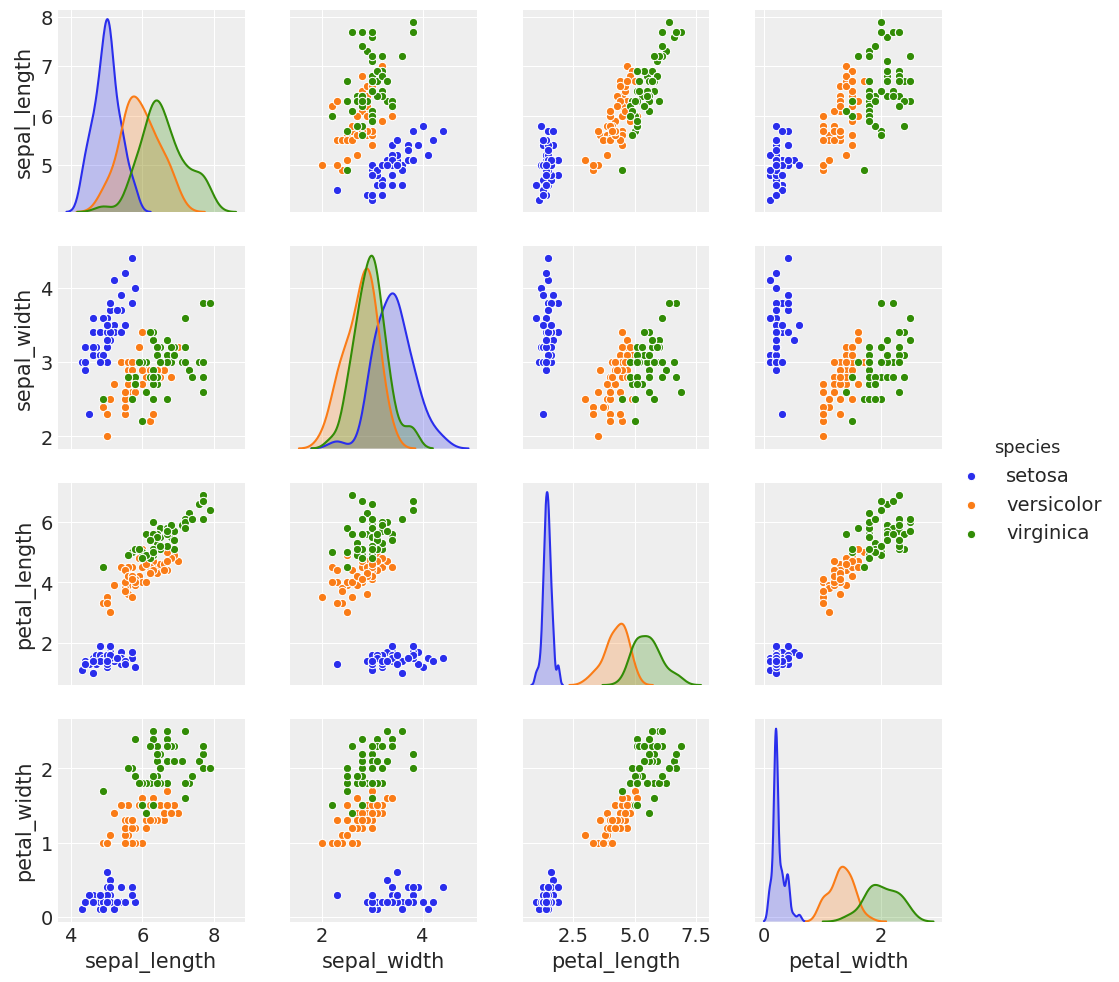

In [60]:
sns.pairplot(iris, hue='species', diag_kind='kde')
plt.savefig('B11197_04_03.png', dpi=300, bbox_inches='tight');

### The logistic model applied to the iris dataset

In [7]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2518.96draws/s]


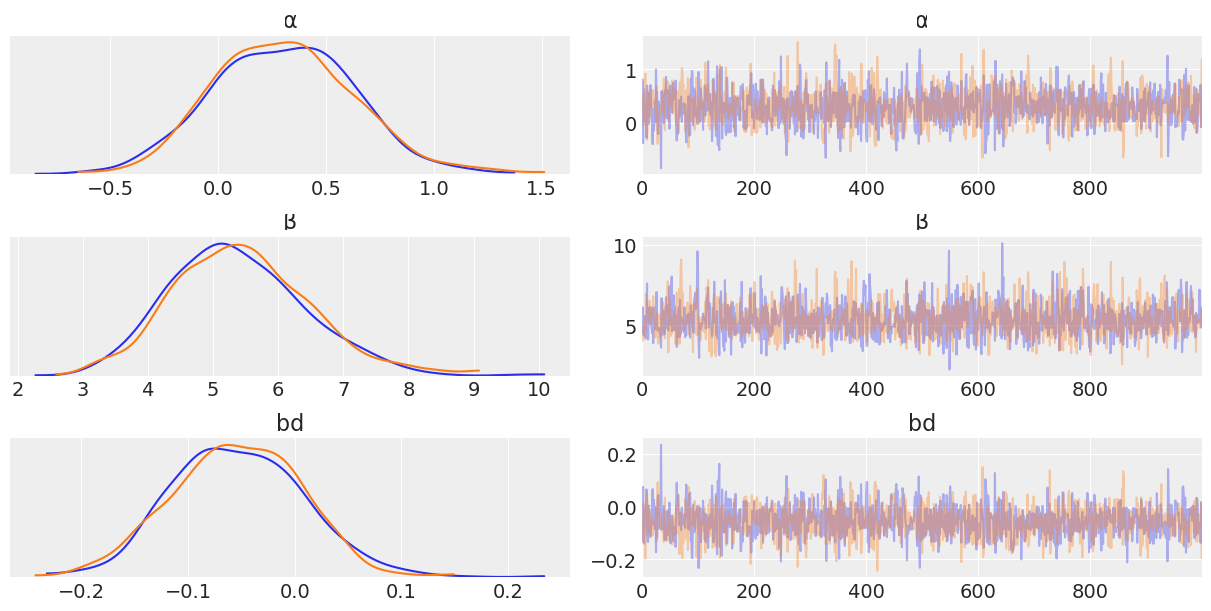

In [8]:
with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    trace_0 = pm.sample(1000)

varnames = ['α', 'β', 'bd']
az.plot_trace(trace_0, varnames);

In [9]:
az.summary(trace_0, varnames)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,0.30,0.33,0.01,-0.34,0.85,1661.0,1.0
β,5.39,1.04,0.02,3.39,7.26,1586.0,1.0
bd,-0.05,0.06,0.00,-0.16,0.06,1767.0,1.0


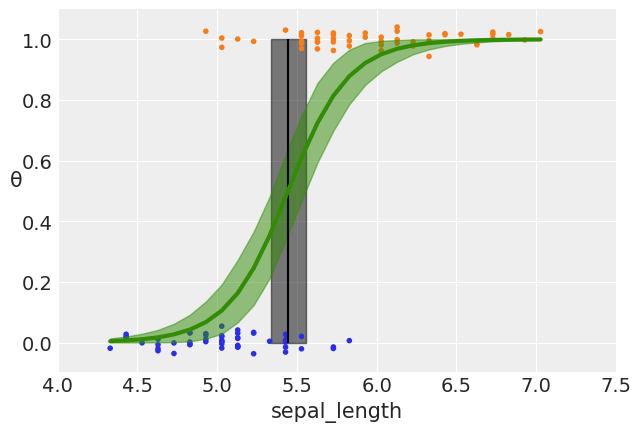

In [10]:
theta = trace_0['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
theta_hpd = az.hpd(trace_0['θ'])[idx]
plt.fill_between(x_c[idx], theta_hpd[:,0], theta_hpd[:,1], color='C2', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks() 
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
plt.savefig('B11197_04_04.png', dpi=300);

# Multiple logistic regression

In [11]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_1 = df[x_n].values

In [12]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    trace_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:12<00:00, 399.52draws/s]


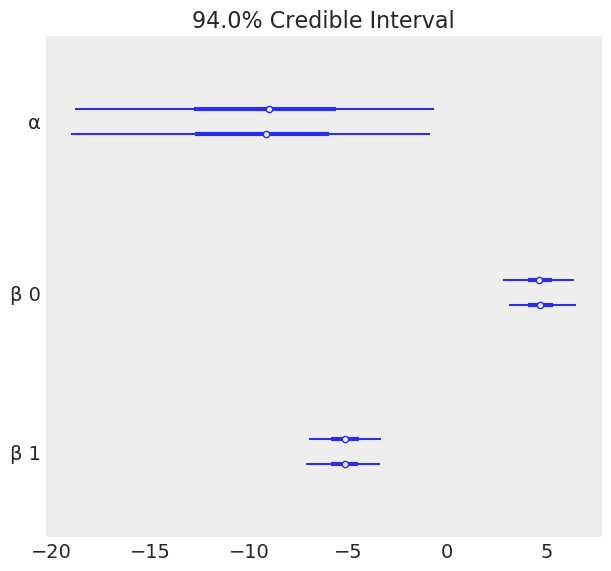

In [13]:
varnames = ['α', 'β'] 
az.plot_forest(trace_1, var_names=varnames);

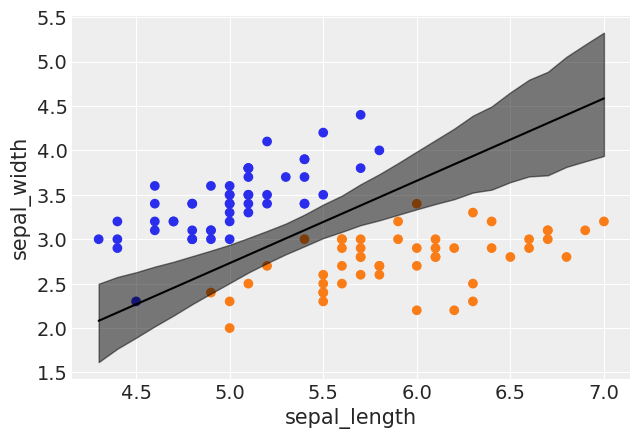

In [14]:
idx = np.argsort(x_1[:,0]) 
bd = trace_1['bd'].mean(0)[idx] 
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_1[:,0][idx], bd, color='k'); 
 
bd_hpd = az.hpd(trace_1['bd'])[idx] 
plt.fill_between(x_1[:,0][idx], bd_hpd[:,0], bd_hpd[:,1], color='k', alpha=0.5); 
 
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])
plt.savefig('B11197_04_05.png', dpi=300);

## Interpreting the coefficients of a logistic regression

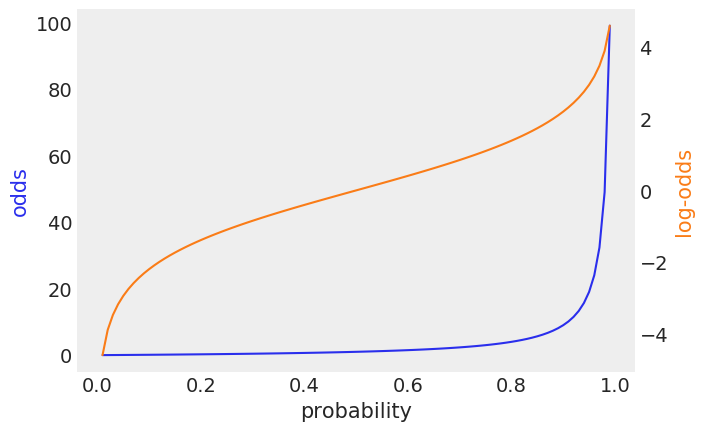

In [15]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'C0')
ax2.plot(probability, np.log(odds), 'C1')

ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
ax1.grid(False)
ax2.grid(False)
plt.savefig('B11197_04_06.png', dpi=300);

In [16]:
df = az.summary(trace_1, var_names=varnames)
df

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,-9.24,4.94,0.06,-18.92,-0.75,1222.0,1.0
β[0],4.70,0.93,0.01,3.11,6.61,1247.0,1.0
β[1],-5.21,0.99,0.01,-7.09,-3.40,1757.0,1.0


In [17]:
x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width 

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)


log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

log_odds_versicolor_f - log_odds_versicolor_i, probability_versicolor_f - probability_versicolor_i

(4.6999999999999975, 0.7034476381856682)

## Dealing with correlated variables

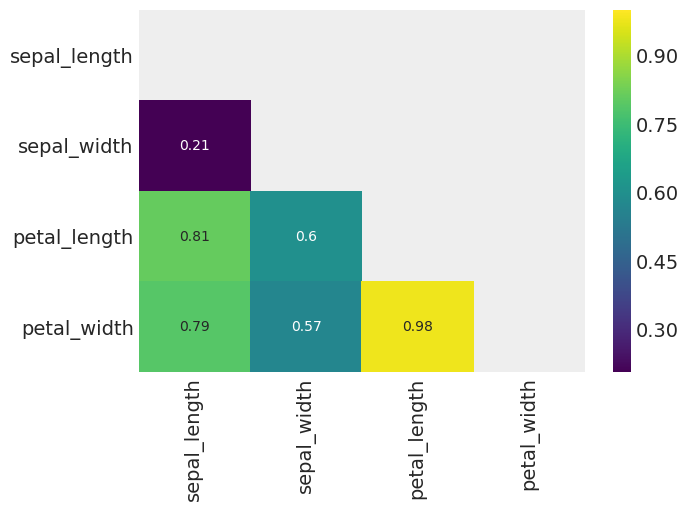

In [18]:
corr = iris[iris['species'] != 'virginica'].corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')
plt.savefig('B11197_04_07.png', dpi=300, bbox_inches='tight');

## Dealing with unbalanced classes

In [19]:
df = iris.query("species == ('setosa', 'versicolor')") 
df = df[45:]  
y_3 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values

In [20]:
with pm.Model() as model_3: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_3, β) 
    θ = 1 / (1 + pm.math.exp(-μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0]) 
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_3) 
 
    trace_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 442.89draws/s]
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7035b419e8>,
      dtype=object)

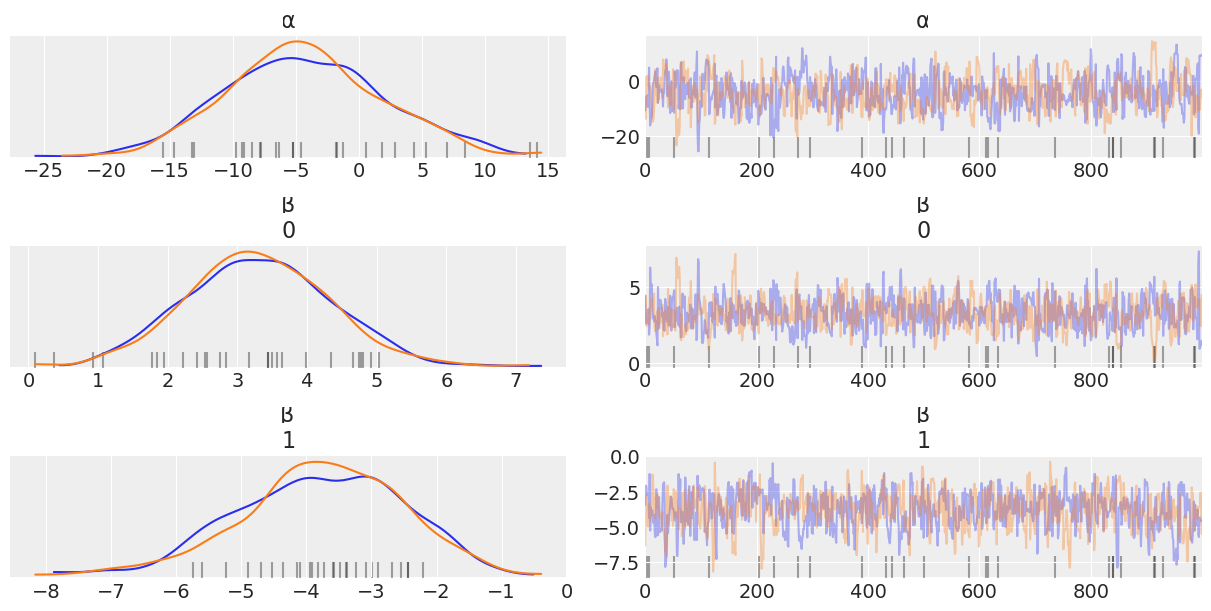

In [21]:
az.plot_trace(trace_3, varnames)

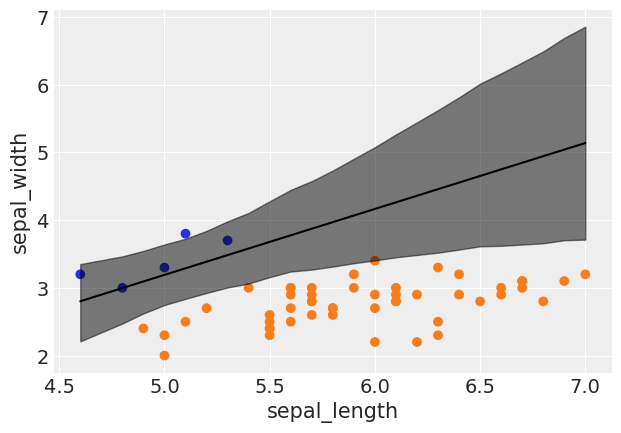

In [22]:
idx = np.argsort(x_3[:,0]) 
bd = trace_3['bd'].mean(0)[idx] 
plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3]) 
plt.plot(x_3[:,0][idx], bd, color='k')
 
bd_hpd = az.hpd(trace_3['bd'])[idx] 
plt.fill_between(x_3[:,0][idx], bd_hpd[:,0], bd_hpd[:,1], color='k', alpha=0.5)
 
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

plt.savefig('B11197_04_08.png', dpi=300);

In [23]:
df = iris.query("species == ('setosa', 'versicolor')") 
df = df[45:]  
y_3 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values
x_3 = (x_3 - x_3.mean()) / x_3.std()

In [24]:
with pm.Model() as model_3: 
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n))
     
    μ = α + pm.math.dot(x_3, β) 
    θ = 1 / (1 + pm.math.exp(-μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0]) 
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_3) 
 
    trace_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1006.27draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7202762495833612, but should be close to 0.8. Try to increase the number of tuning steps.


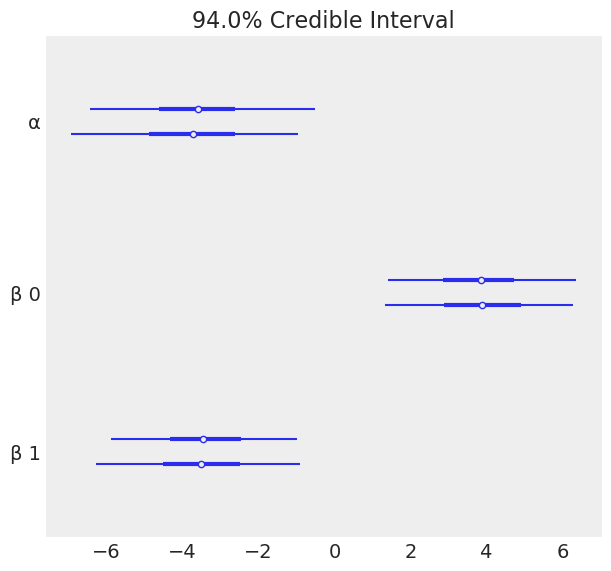

In [25]:
az.plot_forest(trace_3, var_names=['α', 'β']);

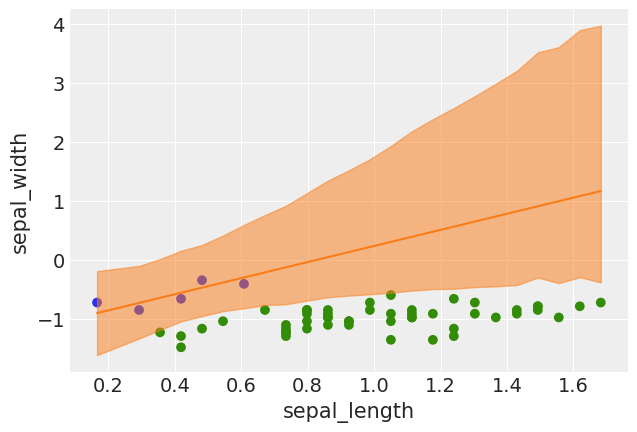

In [26]:
idx = np.argsort(x_3[:,0]) 
bd = trace_3['bd'].mean(0)[idx] 
plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3*2]) 
plt.plot(x_3[:,0][idx], bd, color='C1')
 
bd_hpd = az.hpd(trace_3['bd'])[idx] 
plt.fill_between(x_3[:,0][idx], bd_hpd[:,0], bd_hpd[:,1], color='C1', alpha=0.5)
 
plt.xlabel(x_n[0])
plt.ylabel(x_n[1]);

## Softmax regression

In [27]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

In [28]:
with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sd=5, shape=3)
    β = pm.Normal('β', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_s = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:32<00:00, 153.29draws/s]


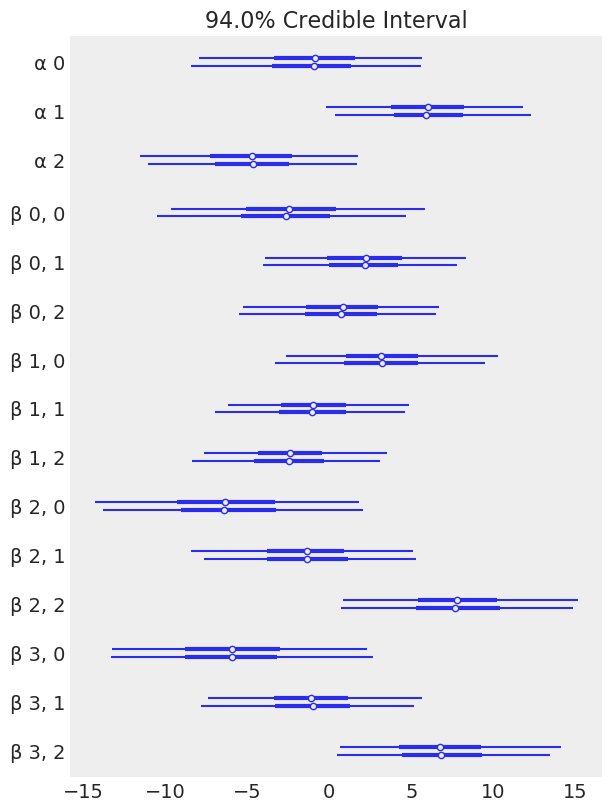

In [29]:
az.plot_forest(trace_s, var_names=['α', 'β']);

In [30]:
data_pred = trace_s['μ'].mean(0)

y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0) for point in data_pred]

f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

'0.98'

In [31]:
with pm.Model() as model_sf:
    α = pm.Normal('α', mu=0, sd=2, shape=2)
    β = pm.Normal('β', mu=0, sd=2, shape=(4,2))
    α_f = tt.concatenate([[0] ,α])
    β_f = tt.concatenate([np.zeros((4,1)) , β], axis=1)
    μ = α_f + pm.math.dot(x_s, β_f)
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_sf = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 289.24draws/s]


## Discriminative and generative models

In [32]:
with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sd=10, shape=2)
    σ = pm.HalfNormal('σ', 10)
    setosa = pm.Normal('setosa', mu=μ[0], sd=σ, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=μ[1], sd=σ, observed=x_0[50:])
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1785.48draws/s]
The acceptance probability does not match the target. It is 0.8824636582599041, but should be close to 0.8. Try to increase the number of tuning steps.


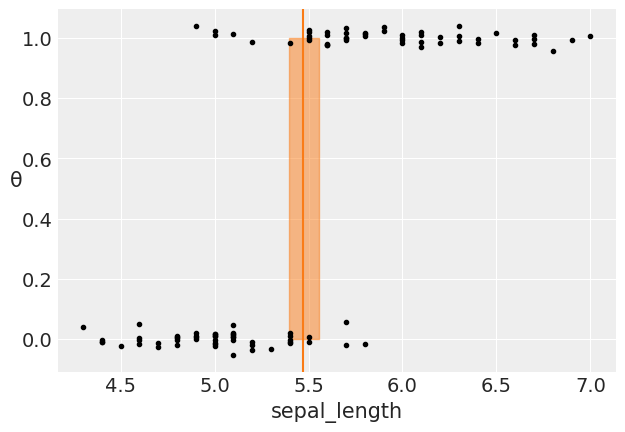

In [33]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hpd(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')
plt.savefig('B11197_04_09.png', dpi=300);

In [34]:
az.summary(trace_lda)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
μ[0],5.01,0.06,0.0,4.89,5.12,1655.0,1.0
μ[1],5.94,0.06,0.0,5.81,6.04,2530.0,1.0
σ,0.45,0.03,0.0,0.39,0.51,2229.0,1.0
bd,5.47,0.04,0.0,5.39,5.56,2081.0,1.0


### The Poisson distribution

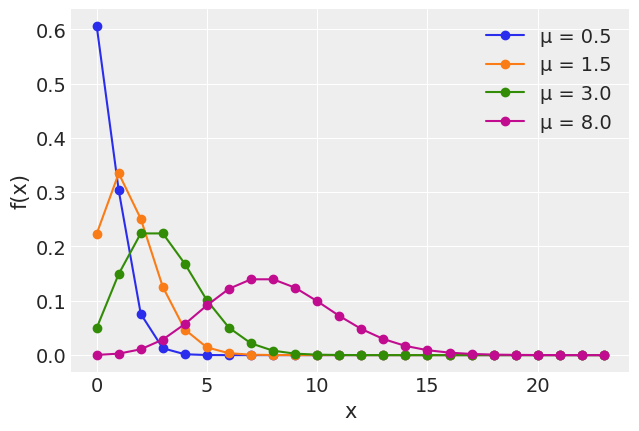

In [35]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.savefig('B11197_04_10.png', dpi=300);

## The Zero-Inflated Poisson model

In [36]:
#np.random.seed(42)
n = 100
θ_real = 2.5
ψ = 0.1

# Simulate some data
counts = np.array([(np.random.random() > (1-ψ)) * np.random.poisson(θ_real)
                   for i in range(n)])

In [37]:
with pm.Model() as ZIP:
    ψ = pm.Beta('ψ', 1, 1)
    θ = pm.Gamma('θ', 2, 0.1)
    y = pm.ZeroInflatedPoisson('y', ψ, θ, observed=counts)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, ψ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2288.08draws/s]


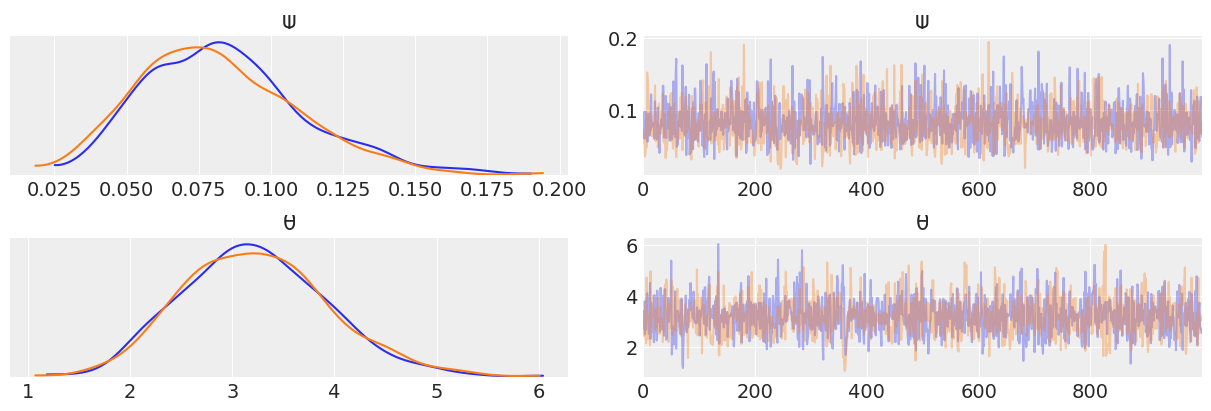

In [38]:
az.plot_trace(trace)
plt.savefig('B11197_04_11.png', dpi=300);

In [39]:
az.summary(trace)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
ψ,0.08,0.03,0.00,0.04,0.14,1954.0,1.0
θ,3.22,0.72,0.01,1.99,4.62,1440.0,1.0


## Poisson regression and ZIP regression

In [40]:
fish_data = pd.read_csv('../data/fish.csv')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α, ψ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 596.49draws/s]


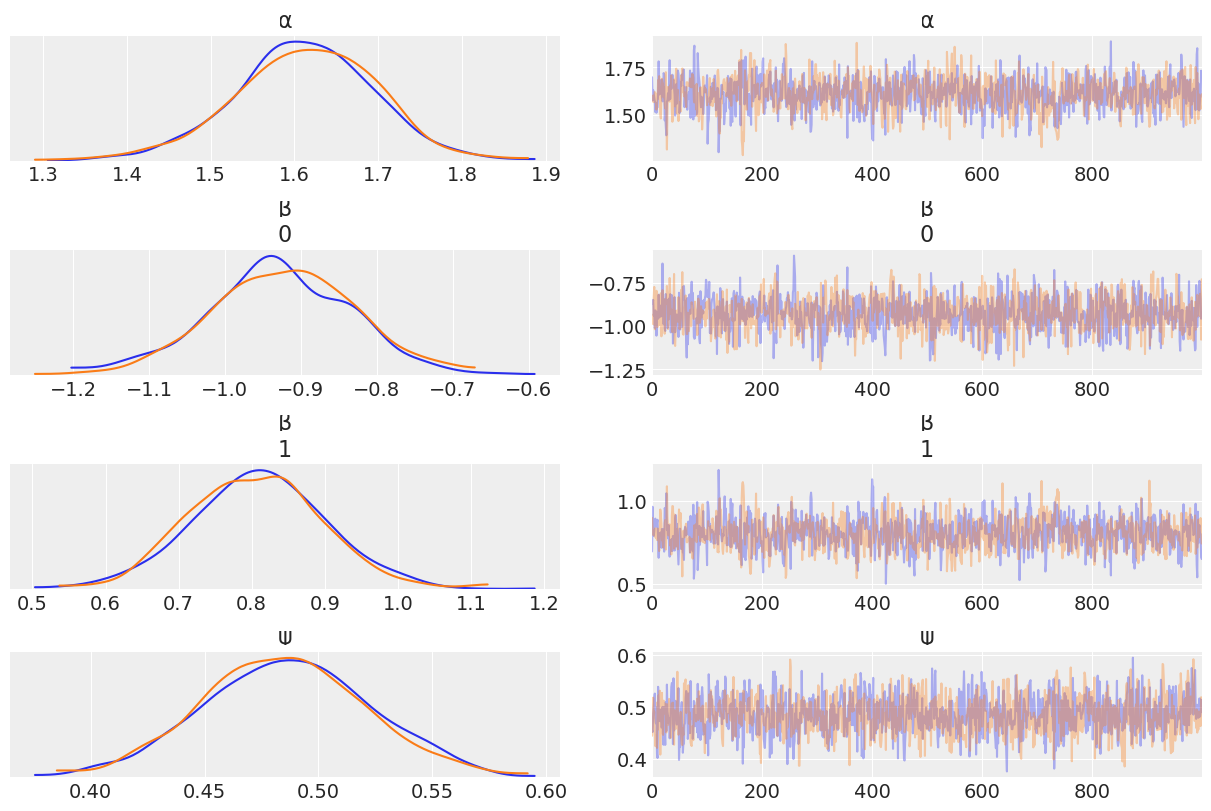

In [41]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 10, shape=2)
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(1000)
az.plot_trace(trace_ZIP_reg);

0.3945537103716011

In [48]:
az.summary(trace_ZIP_reg)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,1.61,0.08,0.0,1.44,1.75,985.0,1.0
β[0],-0.93,0.09,0.0,-1.12,-0.76,1342.0,1.0
β[1],0.81,0.09,0.0,0.65,0.99,1026.0,1.0
ψ,0.48,0.04,0.0,0.42,0.56,1228.0,1.0


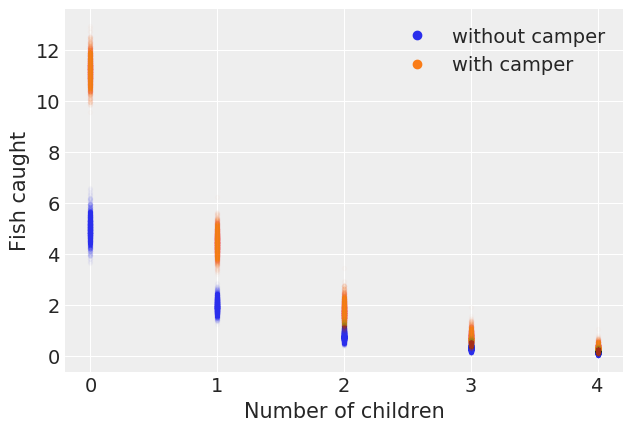

In [42]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
for n in children:
    without_camper = trace_ZIP_reg['α'] + trace_ZIP_reg['β'][:,0] * n
    with_camper = without_camper + trace_ZIP_reg['β'][:,1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))
    
    
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend()
plt.savefig('B11197_04_12.png', dpi=300);

## Robust logistic regression

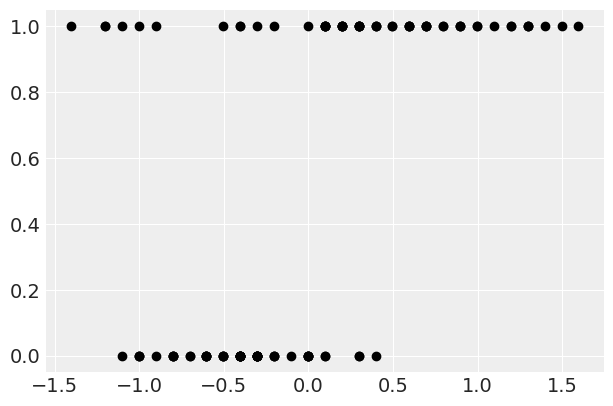

In [43]:
iris = sns.load_dataset("iris") 
df = iris.query("species == ('setosa', 'versicolor')") 
y_0 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length'  
x_0 = df[x_n].values 
y_0 = np.concatenate((y_0, np.ones(6, dtype=int))) 
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4])) 
x_c = x_0 - x_0.mean() 
plt.plot(x_c, y_0, 'o', color='k');

In [44]:
with pm.Model() as model_rlg:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + x_c *  β  
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    π = pm.Beta('π', 1., 1.) 
    p = π * 0.5 + (1 - π) * θ 
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    trace_rlg = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [π, β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1609.71draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


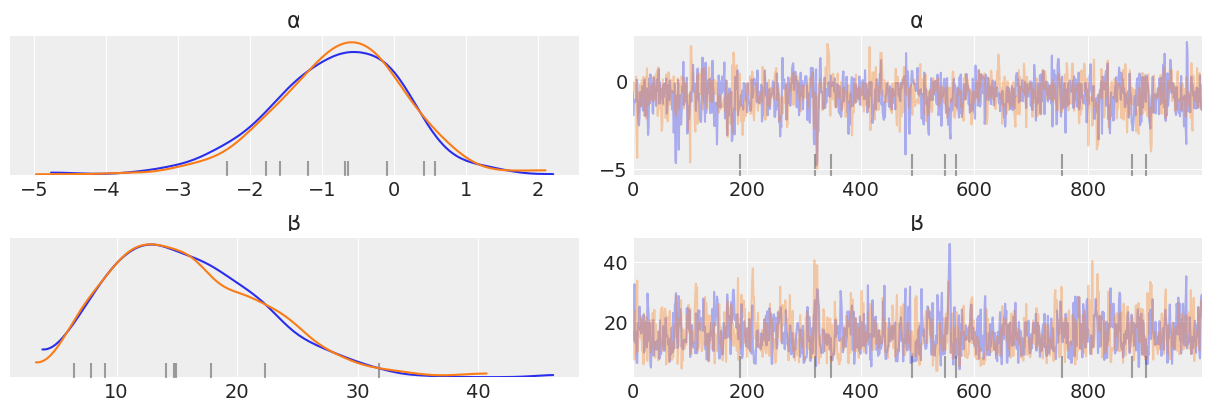

In [45]:
az.plot_trace(trace_rlg, varnames);

In [46]:
az.summary(trace_rlg, varnames)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,-0.80,0.93,0.02,-2.61,0.8,1021.0,1.0
β,15.85,6.23,0.15,5.52,26.8,850.0,1.0


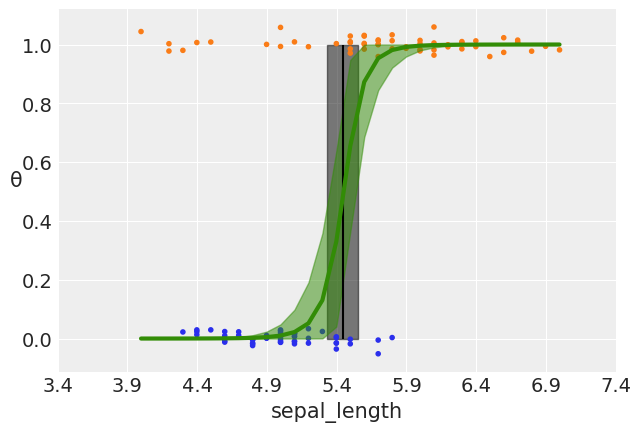

In [47]:
theta = trace_rlg['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3);
plt.vlines(trace_rlg['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_rlg['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
theta_hpd = az.hpd(trace_rlg['θ'])[idx]
plt.fill_between(x_c[idx], theta_hpd[:,0], theta_hpd[:,1], color='C2', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks() 
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
plt.savefig('B11197_04_13.png', dpi=300);